In [1]:
#@title Import data and libraries
#@markdown Let us first download and prepare our dataset directly from our 
#@markdown Google Drive.

# Libraries for operating system and file import/export
import io, os

import matplotlib.pyplot as plt

# For an external release or for using without actual access to GDrive,
# remove the following line and uncomment the line below it.
from oauth2client.client import GoogleCredentials
# from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
from google.colab import files

# Library for labeling lines in plots
!pip install matplotlib-label-lines
from labellines import labelLine, labelLines

# For data wrangling, plotting distributions and investigating correlation
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn import preprocessing
from itertools import combinations

# Commonly used modules
import os
import sys

# Images, plots, display, and visualization
import cv2
from six.moves import urllib

from sklearn.model_selection import train_test_split

In [129]:
# Define some standard figure parameters
plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=6) 
plt.rc('ytick', labelsize=6) 
plt.rcParams["figure.figsize"] = (2.7,2.7)

# Get a nice colormap, merge light and dark theme
cmap4 = sns.color_palette("dark:#006eb7", n_colors=5, as_cmap=False) + \
        sns.color_palette("light:#006eb7", n_colors=5, as_cmap=False)
cmap4 = list(cmap4[i] for i in [1, 3, 8, 6] )
cmap10 = sns.color_palette("dark:#006eb7", n_colors=10, as_cmap=False)

cmap4 = ['blue', '#0066ff', '#912791', 'black']

In [130]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

filekeys={}
filekeys['epsout_effect.csv'] = '1OGi22TWxJulcEG3G3YSPv-TXV4sCBfuL'
filekeys['data_overview.csv'] = '1-V6b0Dn-DDc1-vgib__KuJCewPHRYcQe'
filekeys['data_overview_substituents.csv'] = '1zZjhK4-wCrDONtoSqVpPoXvNA1ldeIaP'
filekeys['data_metalions_IPr.csv'] = '1AbJmJ515Pagbt-7--M43MFGVMc75EySm'
filekeys['data_metalions_MIC.csv'] = '1WFWj1bpk2Mi9LVg7EqSpUMTt6Hnf5f50'
filekeys['data_metalions_thiazole.csv'] = '1xEvh5T8JWi6UP0cuxTJ3o2nfVpn-uXJX'

auth.authenticate_user()
drive_service = build('drive', 'v3')

# Define filenames and create the directory
filedir = "/content/.baik/"
os.makedirs(filedir, exist_ok=True)

# Download epsout_effect.csv from Google Drive
for filekey in filekeys:
    
    filename = filedir + filekey

    request = drive_service.files().get_media(fileId=filekeys[filekey])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done == False:
        status, done = downloader.next_chunk()
        print("{} download %d%%.".format(filekey) % int(status.progress() * 100))
    os.chmod(filename, 600)

epsout_effect.csv download 100%.
data_overview.csv download 100%.
data_overview_substituents.csv download 100%.
data_metalions_IPr.csv download 100%.
data_metalions_MIC.csv download 100%.
data_metalions_thiazole.csv download 100%.


In [131]:
# Make dataframes from our .csv files
df_epsout = pd.read_csv(filedir +
                        'epsout_effect.csv',
                        index_col=0)
df_dataoverview = pd.read_csv(filedir +
                        'data_overview.csv',
                        index_col=0)
df_dataoverview_substituents = pd.read_csv(filedir +
                        'data_overview_substituents.csv',
                        index_col=0)
df_metal_ions_IPr = pd.read_csv(filedir +
                        'data_metalions_IPr.csv',
                        index_col=0)
df_metal_ions_MIC = pd.read_csv(filedir +
                        'data_metalions_MIC.csv',
                        index_col=0)
df_metal_ions_thiazole = pd.read_csv(filedir +
                        'data_metalions_thiazole.csv',
                        index_col=0)


In [132]:
for item in [df_dataoverview, df_dataoverview_substituents]:
    # Remove units from the column names
    item.columns = item.columns.str.replace('\\n\[kcal\ mol\−1\]', '', regex=True)
    item.columns = item.columns.str.replace('\\n\[kcal\ mol\-1\]', '', regex=True)
    item.columns = item.columns.str.replace('\\n\[kcal\ mol\?1\]', '', regex=True)
    
    item.columns = item.columns.str.replace('\\n\[eV\]', '', regex=True)
    item.columns = item.columns.str.replace('\\n\[\%\]', '', regex=True)

    # Drop the column that is used for showing ChemDraw images and the now empty
    # notes column
    for label in ["Carbene CR’2", "Substituent R"]:
        try:
            item.drop(columns=[label], inplace=True)
        except:
            pass



In [62]:
df_epsout.head()

,Label,Enolate ox,Enol. ox,S-T,dG addition,dG 1H,dG 1H'',Stable taut,dG addition taut,Electrolysis,Enol ox,pKa,Carbene ox,Carbene HOMO,Carbene LUMO,Carbene cation HOMO,Notes
Entry,,,,,,,,,,,,,,,,,
11≡1,1e,-2.27,-1.10,17.20,14.28,-4.10,1.98,1H,10.18,-2.10,-0.88,36.3,1.05,-4.938,-1.228,NaN,NaN
12,1eb,-1.59,-0.54,8.07,7.77,-10.55,8.73,1H,-2.78,-1.53,-0.34,26.7,1.05,NaN,NaN,NaN,NaN
13,1ec,-2.36,-1.30,17.23,15.60,-0.59,2.60,1H,15.00,-2.13,-1.05,36.8,1.05,NaN,NaN,NaN,NaN
14,1ed,-2.00,-0.92,18.18,16.58,-15.40,-0.41,1H,1.18,-1.91,-0.83,33.0,1.05,NaN,NaN,NaN,NaN
15,1ee,-2.02,-0.78,18.39,8.95,-13.94,3.99,1H,-4.99,-1.98,-0.73,34.4,1.05,NaN,NaN,NaN,NaN
16,1ef,-2.41,-1.21,17.91,9.32,3.27,5.54,1H',9.32,-2.17,-1.18,37.4,1.05,NaN,NaN,NaN,NaN
S21,S1ea,-2.40,-1.34,19.10,16.52,7.90,1.03,1H',16.52,-2.35,-1.12,40.6,1.05,NaN,NaN,NaN,NaN


In [61]:
df_dataoverview["Vbur CO"] = df_dataoverview["Vbur CO"].str.rstrip('%').astype('float') / 100.0
df_dataoverview_substituents["Vbur CO"] = df_dataoverview_substituents["Vbur CO"].str.rstrip('%').astype('float') / 100.0
df_dataoverview.head()

KeyError: ignored

# Solvation
Let us plot the impact of changing the dielectric constant on the absolute and relative redox potentials for three carbenes.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

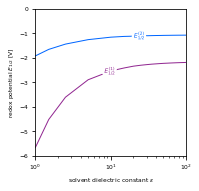

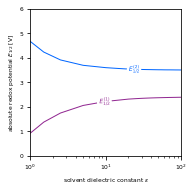

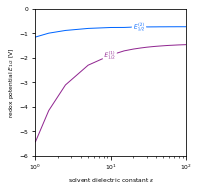

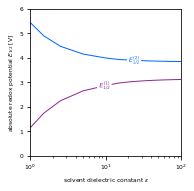

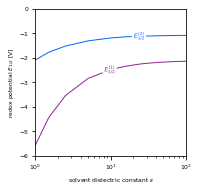

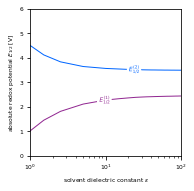

In [8]:
carbenes = ['IPr', 'thiazole', 'MIC']

for carbene in carbenes:
    for relative in ['rel', '']:

        filename_png='solvation_effect_' + relative + carbene + '.png'

        fig = plt.figure()
        plt.xscale('log')

        ax=fig.add_subplot(1,1,1)


        ax.plot(df_epsout['E1' + relative + ' ' + carbene], '-', c=cmap4[2], lw=1, label = '$E_{1/2}^{(1)}$')
        ax.plot(df_epsout['E2' + relative + ' ' + carbene], '-', c=cmap4[1], lw=1, label = '$E_{1/2}^{(2)}$')

        labelLines(plt.gca().get_lines(), align=False, xvals=(4,60), zorder=2.5)
        
        #ax.axvspan(1, 4, facecolor='0.1', alpha=0.2, zorder=-100)

        ax.set_xlabel("solvent dielectric constant $\epsilon$")

        if relative=='':
            ax.set_ylabel(r"absolute redox potential $E_{1/2}$ [$\mathrm{V}$]")
            ax.set_ylim(0, 6)
        else:
            ax.set_ylabel(r"redox potential $E_{1/2}$ [$\mathrm{V}$]")
            ax.set_ylim(-6, 0)

        ax.set_xlim(1, 100)
        plt.savefig(filename_png, bbox_inches='tight', dpi=300)

        files.download(filename_png)


We need to keep in mind, however, that this will impact smaller ions stronger. An opposing effect is expected for the small molecules that we reduce, so let us put that into perspective by plotting E(1) vs. the redox potential of the reaction PhI -> Ph radical and I-. We will also plot the delta G of this reaction in the same figure.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

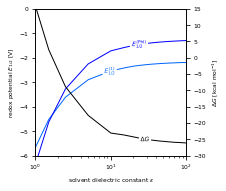

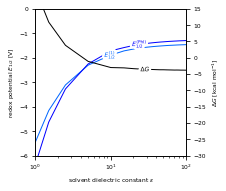

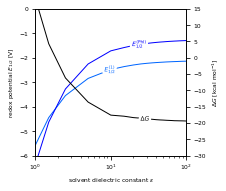

In [9]:
carbenes = ['IPr', 'thiazole', 'MIC']

for carbene in carbenes:
    for relative in ['rel']:

        filename_png='solvation_effect_PhI_' + relative + carbene + '.png'

        fig = plt.figure()
        plt.xscale('log')

        ax=fig.add_subplot(1,1,1)


        ax.plot(df_epsout['E1' + relative + ' ' + carbene], '-', c=cmap4[1], lw=1, label = '$E_{1/2}^{(1)}$')
        ax.plot(df_epsout['E' + relative + ' PhI'], '-', c=cmap4[0], lw=1, label = '$E_{1/2}^{(\mathrm{PhI})}$')
        labelLines(plt.gca().get_lines(), align=False, xvals=(4,60), zorder=2.5)
        ax2 = ax.twinx()
        ax2.plot(df_epsout['dG ' + carbene], '-', c=cmap4[3], lw=1, label = r"$\Delta G$")
        labelLines(plt.gca().get_lines(), align=False, zorder=2.5)

        #ax.axvspan(1, 1.9, facecolor='0.1', alpha=0.2, zorder=-100)

        ax.set_xlabel("solvent dielectric constant $\epsilon$")

        if relative=='':
            ax.set_ylabel(r"absolute redox potential $E_{1/2}$ [$\mathrm{V}$]")
            ax.set_ylim(0, 6)
        else:
            ax.set_ylabel(r"redox potential $E_{1/2}$ [$\mathrm{V}$]")
            ax.set_ylim(-6, 0)

        ax2.set_ylabel(r"$\Delta G$ [$\mathrm{kcal\/\/mol^{-1}}$]")
        ax.set_xlim(1, 100)
        ax2.set_ylim(-30, 15)
        plt.savefig(filename_png, bbox_inches='tight', dpi=300)

        files.download(filename_png)


# Impact of metal coordination
Alkali metal bases are often used for deprotonation Breslow intermediates. Let us investigate how coordination to these cations (ion pairing) influences the expected redox potentials in different solvents.

In [133]:
metal_dfs = {"df_metal_ions_IPr":df_metal_ions_IPr,
             "df_metal_ions_thiazole": df_metal_ions_thiazole,
             "df_metal_ions_MIC": df_metal_ions_MIC}

for df in metal_dfs:
    # Take first row as column names and transpose
    metal_dfs[df].columns = metal_dfs[df].iloc[0]
    metal_dfs[df] = metal_dfs[df][1:]
    # Transpose to get our Epsilon as index
    metal_dfs[df] = metal_dfs[df].transpose()
    # Convert the dtypes to floats
    metal_dfs[df].index = metal_dfs[df].index.astype(float)

# Retrieve the new dfs from the dictionary
df_metal_ions_IPr = metal_dfs["df_metal_ions_IPr"]
df_metal_ions_thiazole = metal_dfs["df_metal_ions_thiazole"]
df_metal_ions_MIC = metal_dfs["df_metal_ions_MIC"]

In [134]:
df_metal_ions_MIC

Description,Radical,Enolate,Cs-enolate,K-enolate,Na-enolate,Li-enolate,Fc,Fc+,Cs+,K+,Na+,Li+
Epsilon,,,,,,,,,,,,
4.5,-47612.954230,-47615.027604,-48154.998162,-48379.142381,-52026.648450,-47817.898212,-13880.031485,-13875.026050,-539.874449,-763.958291,-4411.438044,-202.507438
7.6,-47613.044861,-47615.251363,-48155.153405,-48379.298058,-52026.791985,-47818.040446,-13880.055769,-13875.231163,-540.171494,-764.310841,-4411.885995,-203.054260
37.5,-47613.168016,-47615.569222,-48155.378899,-48379.517480,-52026.997965,-47818.236886,-13880.087859,-13875.470966,-540.515805,-764.718464,-4412.404197,-203.681739


We know that our solvent model extrapolates proportional to 1/eps on the energy. We can use this to fit our individual energies to different solvents without explicitly calculating all of them. We will use the three that we already have.

In [135]:
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

In [136]:
def fit_metal_coord(E_df, plot):
    
    i = 1

    fit_df = pd.DataFrame()
    fit_data = ["polynomial_1", "polynomial_2", "determination"]
    fit_df["fit_data"] = fit_data
    fit_df.set_index("fit_data", inplace=True)

    for col in E_df.columns:
        

        #fit = polyfit(((E_df.index)/(1-(E_df.index))),
        #              E_df[col], 1)
        fit = polyfit(((1)/((E_df.index))),
                      E_df[col], 1)
        
        x = np.arange(2,40, 0.2)
        #y = fit['polynomial'][0] * (x/(1-x)) + fit['polynomial'][1]
        y = fit['polynomial'][0] * (1/(x)) + fit['polynomial'][1]
        if plot:
            plt.subplot(np.round(len(E_df.columns))/2+1,2,i)
            plt.plot(x,y)
            plt.plot(E_df[col], "o")
        fit_lst = [fit['polynomial'][0], fit['polynomial'][1], fit['determination']]
        fit_df[col] = fit_lst

        i += 1

    return fit_df

In [137]:
kbT_inv = 38.9217445 # 1/kT in eV/K

def RedPot(E_df, species, x):
    fit_df = fit_metal_coord(E_df, False)
    #RedPot = fit_df[species][0] * (x/(1-x)) + fit_df[species][1]
    RedPot = fit_df[species][0] * (1/(x)) + fit_df[species][1]
    return RedPot

def metal_coord_figure(E_df, metals, xrange, download,
                           filename_png):


    fig = plt.figure(figsize=(5.4,5.4))

    i = 0
    x = np.arange(xrange[0], xrange[1], 0.2)

    axs = []
    axs.append(plt.subplot2grid((2,2),(0, 0)))
    axs.append(plt.subplot2grid((2,2),(0, 1)) if len(metals)>1 else None)
    axs.append(plt.subplot2grid((2,2),(1, 0)) if len(metals)>2 else None)
    axs.append(plt.subplot2grid((2,2),(1, 1)) if len(metals)>3 else None)


    for metal in metals:
        
        
        #Enolate
        y_enolate = RedPot(E_df, "Radical",x) - RedPot(E_df, "Enolate",x) -RedPot(E_df, "Fc+",x) + RedPot(E_df, "Fc",x)
        axs[i].plot(x,y_enolate, "b--")

        y_enolate_explicit = E_df["Radical"] - E_df["Enolate"] - E_df["Fc+"] + E_df["Fc"]
        axs[i].plot(y_enolate_explicit, "ob")

        #K-enolate
        #plt.subplot(1,3,2)

        y_Kenolate = RedPot(E_df, "Radical",x) + RedPot(E_df, metal+"+",x) - RedPot(E_df, metal+"-enolate",x) - RedPot(E_df, "Fc+",x) + RedPot(E_df, "Fc",x)
        axs[i].plot(x,y_Kenolate, "g--")

        y_Kenolate_explicit = E_df["Radical"] + E_df[metal+"+"] - E_df[metal+"-enolate"] - E_df["Fc+"] + E_df["Fc"]
        axs[i].plot(y_Kenolate_explicit, "og")

        #Boltzmann

        y_Boltzmann = RedPot(E_df, "Radical",x) + RedPot(E_df, metal+"+",x) - ((np.exp(-(kbT_inv * (
            RedPot(E_df, metal+"-enolate",x) - RedPot(E_df, "Enolate",x) - RedPot(E_df, metal+"+",x)))) * RedPot(E_df, metal+"-enolate",x) + RedPot(E_df, "Enolate",x) + RedPot(E_df, metal+"+",x) ) /
            (np.exp(-(kbT_inv * (RedPot(E_df, metal+"-enolate",x) - RedPot(E_df, "Enolate",x) - RedPot(E_df, metal+"+",x))))+1)) - RedPot(E_df, "Fc+",x) + RedPot(E_df, "Fc",x)
        axs[i].plot(x,y_Boltzmann, "r", alpha=0.85)

        y_Boltzmann_explicit = E_df["Radical"] + E_df[metal+"+"] - ((np.exp(-(kbT_inv * (
            E_df[metal+"-enolate"] - E_df["Enolate"] - E_df[metal+"+"]))) * E_df[metal+"-enolate"] + E_df["Enolate"] + E_df[metal+"+"] ) /
            (np.exp(-(kbT_inv * (E_df[metal+"-enolate"] - E_df["Enolate"] - E_df[metal+"+"])))+1)) - E_df["Fc+"] + E_df["Fc"]

        axs[i].plot(y_Boltzmann_explicit, "xr", alpha=0.85, markersize=7)

        axs[i].set_xlabel("solvent dielectric constant $\epsilon$")
        axs[i].set_xlim(xrange[0], xrange[1])
        axs[i].set_ylabel("$E_{1/2}^{(1)}$ [$\mathrm{V}$]")
        axs[i].set_title(metal)

        i+=1
    plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)
    
    if download==True:
        plt.savefig(filename_png, bbox_inches='tight', dpi=300)
        files.download(filename_png)
    else:
        pass
    return



In [138]:
def metal_coord_figure_all(E_df, metals, xrange, yrange, labelrange, download,
                           filename_png):
      
    i = 0
    x = np.arange(xrange[0], xrange[1], 0.2)
    #Boltzmann
    for metal in metals:
        y_Boltzmann = RedPot(E_df, "Radical",x) + RedPot(E_df, metal+"+",x) -\
                ((np.exp(-(kbT_inv * (\
                RedPot(E_df, metal+"-enolate",x) - RedPot(E_df, "Enolate",x) -\
                RedPot(E_df, metal+"+",x)))) * RedPot(E_df, metal+"-enolate",x) +\
                RedPot(E_df, "Enolate",x) + RedPot(E_df, metal+"+",x) ) /\
                (np.exp(-(kbT_inv * (RedPot(E_df, metal+"-enolate",x) -\
                RedPot(E_df, "Enolate",x) - RedPot(E_df, metal+"+",x))))+1)) -\
                RedPot(E_df, "Fc+",x) + RedPot(E_df, "Fc",x)
        plt.plot(x,y_Boltzmann, c=cmap4[i], alpha=0.85, label=metal)
        i+=1
    labelLines(plt.gca().get_lines(), xvals=(labelrange[0], labelrange[1]),
               align=True, zorder=2.5)


    plt.xlabel("solvent dielectric constant $\epsilon$")
    plt.ylabel("redox potential $E_{1/2}$ [$\mathrm{V}$]")
    plt.xlim(xrange[0], xrange[1])
    plt.ylim(yrange[0], yrange[1])

    if download==True:
        plt.savefig(filename_png, bbox_inches='tight', dpi=300)
        files.download(filename_png)
    else:
        pass

    return
    



,Radical,Enolate,Cs-enolate,K-enolate,Na-enolate,Li-enolate,Fc,Fc+,Cs+,K+,Na+,Li+
fit_data,,,,,,,,,,,,
polynomial_1,0.986153,2.694465,1.761538,1.609189,1.602817,1.400896,0.288735,2.275415,3.279720,3.887199,4.940525,6.004324
polynomial_2,-40898.020790,-40901.700420,-41440.404356,-41664.637652,-45312.359377,-41103.646411,-13880.094989,-13875.531300,-540.603192,-764.822183,-4412.535982,-203.842630
determination,0.998530,0.998320,0.998285,0.999502,0.999295,0.999203,0.998581,0.999992,1.000000,1.000000,1.000000,0.999994


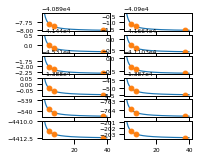

In [139]:
fit_metal_coord(df_metal_ions_IPr, True)

,Radical,Enolate,Cs-enolate,K-enolate,Na-enolate,Li-enolate,Fc,Fc+,Cs+,K+,Na+,Li+
fit_data,,,,,,,,,,,,
polynomial_1,0.771932,3.086631,2.139681,2.233066,2.310394,2.057915,0.288735,2.275415,3.279720,3.887199,4.940525,6.004324
polynomial_2,-33267.072780,-33270.168360,-33810.116580,-34034.396440,-37682.085270,-33473.321307,-13880.094989,-13875.531300,-540.603192,-764.822183,-4412.535982,-203.842630
determination,0.999942,0.997469,0.999494,0.999406,0.999579,0.999275,0.998581,0.999992,1.000000,1.000000,1.000000,0.999994


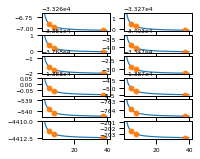

In [140]:
fit_metal_coord(df_metal_ions_thiazole, True)

,Radical,Enolate,Cs-enolate,K-enolate,Na-enolate,Li-enolate,Fc,Fc+,Cs+,K+,Na+,Li+
fit_data,,,,,,,,,,,,
polynomial_1,1.095325,2.776414,1.952223,1.922636,1.791879,1.735518,0.288735,2.275415,3.279720,3.887199,4.940525,6.004324
polynomial_2,-47613.194614,-47615.634842,-48155.424408,-48379.563140,-52027.040051,-47818.278618,-13880.094989,-13875.531300,-540.603192,-764.822183,-4412.535982,-203.842630
determination,0.997931,0.996655,0.995906,0.996901,0.996322,0.997498,0.998581,0.999992,1.000000,1.000000,1.000000,0.999994


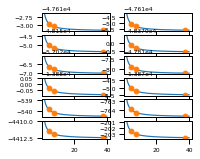

In [141]:
fit_metal_coord(df_metal_ions_MIC, True)

We get 0.98 or greater determination in all cases, confirming that the Poisson-Boltzmann solvation model is implemented proportional to 1/eps.

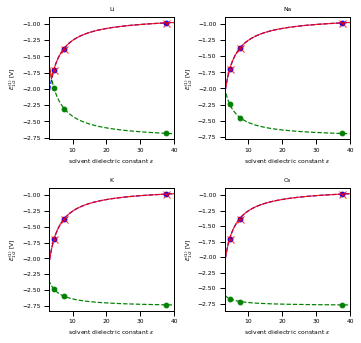

In [145]:
metal_coord_figure(E_df=df_metal_ions_IPr,
                   metals=["Li", "Na", "K", "Cs"],
                   xrange=(3,40),
                   download=False,
                   filename_png="metal_coord_IPr_fit.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

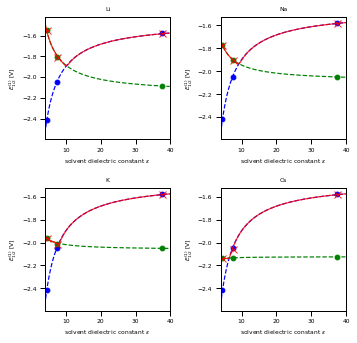

In [143]:
metal_coord_figure(E_df=df_metal_ions_thiazole,
                   metals=["Li", "Na", "K", "Cs"],
                   xrange=(4,40),
                   download=True,
                   filename_png="metal_coord_thiazole_fit.png")

All three cases have more stable dissociated enolated throughout the different solvent polarities. Let us look at the MIC.

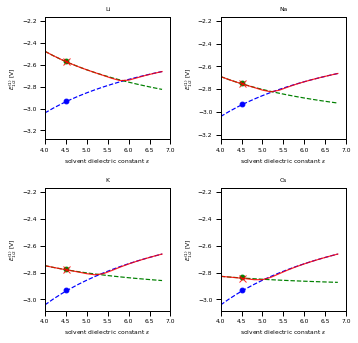

In [144]:
metal_coord_figure(E_df=df_metal_ions_MIC,
                   metals=["Li", "Na", "K", "Cs"],
                   xrange=(4,7),
                   download=False,
                   filename_png="metal_coord_MIC_fit.png")

In the MIC, all 3 cases show an area with low polarity solvents that is sensitive to metal coordination.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

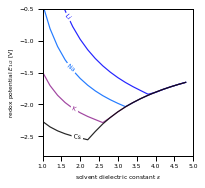

In [156]:
metal_coord_figure_all(E_df=df_metal_ions_IPr,
                   metals=["Li", "Na", "K", "Cs"],
                   xrange=(1,5),
                   yrange=(-2.8,-0.5),
                   labelrange=(1.6,2),
                   download=True,
                   filename_png="metal_coord_IPr.png")

Only in very low dielectric constants, we will see ion pairing begin to influence the redox potential with IPr.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

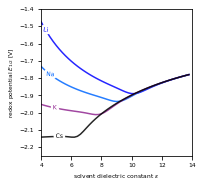

In [22]:
metal_coord_figure_all(E_df=df_metal_ions_thiazole,
                   metals=["Li", "Na", "K", "Cs"],
                   xrange=(4,14),
                   yrange=(-2.25,-1.4),
                   labelrange=(4,5.5),
                   download=True,
                   filename_png="metal_coord_thiazole.png")

A much more pronounced effect is seen with the thiazole.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

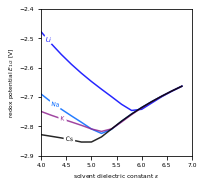

In [23]:
metal_coord_figure_all(E_df=df_metal_ions_MIC,
                   metals=["Li", "Na", "K", "Cs"],
                   xrange=(4,7),
                   yrange=(-2.9,-2.4),
                   labelrange=(4,4.7),
                   download=True,
                   filename_png="metal_coord_MIC.png")

The MIC is in between the two previous cases.

# DATA OVERVIEW EXPLORATION

In [24]:
# Let us also look into the simplified HOMO/LUMO based methods for calculating
# hardness and electronegativity based on Koopman's theorem I = -epsilon and
# based on the wild guess that the LUMO would in any way correlate with the
# electron affinity.
df_dataoverview["HOMO-LUMO"] = (df_dataoverview["Carbene HOMO"]-df_dataoverview["Carbene LUMO"])/2
df_dataoverview["HOMO+LUMO"] = (df_dataoverview["Carbene HOMO"]+df_dataoverview["Carbene LUMO"])/2
df_dataoverview["EN Cat"] = (-df_dataoverview["Carbene cation HOMO"]+df_dataoverview["Carbene HOMO"])/2
df_dataoverview["Hardness Cat"] = (-df_dataoverview["Carbene cation HOMO"]-df_dataoverview["Carbene HOMO"])/2
df_dataoverview

,Label,Enolate ox,Enol. ox,S-T,dG addition,dG 1H,dG 1H'',Stable taut,dG addition taut,Electrolysis,Enol ox,pKa,Carbene ox,Carbene HOMO,Carbene LUMO,Carbene cation HOMO,SOMO,Vbur CO,fract. spin d. CO,RadStabScore CO,Notes,HOMO-LUMO,HOMO+LUMO,EN Cat,Hardness Cat
Entry,,,,,,,,,,,,,,,,,,,,,,,,,
1,1a,-1.58,-0.72,26.60,10.97,-10.73,-13.20,1H'',-2.23,-1.57,-0.57,27.4,1.10,-5.052,-1.506,-9.972,NaN,55.83%,0.110,100.33,NaN,-1.7730,-3.2790,2.4600,7.5120
2,1b,-1.50,-0.93,18.44,15.98,-5.14,-10.51,1H'',5.47,-1.65,-0.61,28.7,1.19,-5.223,-2.123,-9.256,NaN,59.26%,0.104,104.06,NaN,-1.5500,-3.6730,2.0165,7.2395
3,1c,-2.22,-1.12,3.54,12.89,-5.45,-0.07,1H,7.44,-1.94,-0.95,33.6,0.91,-4.651,-2.137,-8.879,NaN,66.30%,0.153,108.65,NaN,-1.2570,-3.3940,2.1140,6.7650
4,1d,-2.16,-1.59,2.60,6.37,4.38,5.21,1H',6.37,-2.00,-1.40,34.7,0.43,-4.287,-2.180,-8.432,NaN,67.20%,0.146,109.90,NaN,-1.0535,-3.2335,2.0725,6.3595
5,1e,-2.27,-1.10,17.20,14.28,-4.10,1.98,1H,10.18,-2.10,-0.88,36.3,1.05,-4.938,-1.228,-9.116,NaN,70.82%,0.173,112.17,NaN,-1.8550,-3.0830,2.0890,7.0270
6,1f,-1.94,-1.05,23.30,13.39,-8.93,-3.15,1H,4.45,-1.97,-0.57,34.1,0.84,-4.784,-1.122,-8.966,NaN,72.63%,0.127,116.28,NaN,-1.8310,-2.9530,2.0910,6.8750
7,1g,-1.05,-0.31,21.02,3.69,-9.56,-17.67,1H'',-13.98,-1.65,0.37,28.7,0.93,-4.986,-2.808,-9.089,NaN,71.25%,0.046,118.95,NaN,-1.0890,-3.8970,2.0515,7.0375
8,1h,-2.26,-1.43,21.05,9.17,-2.84,-10.80,1H'',-1.63,-2.47,-1.06,42.6,0.38,-4.197,-0.149,-9.336,NaN,57.03%,0.164,98.83,NaN,-2.0240,-2.1730,2.5695,6.7665
9,1i,-1.89,-1.14,20.74,18.23,-18.44,-22.66,1H'',-4.43,-2.16,-0.58,37.4,-0.65,-3.634,0.146,-8.684,NaN,71.64%,0.091,117.09,NaN,-1.8900,-1.7440,2.5250,6.1590


In [28]:
y_cols = ['Enolate ox', 'Enol. ox', 'Electrolysis', 'Enol ox']

x_cols = [ 'pKa', 'dG addition', 'Carbene ox', 'Carbene HOMO', 'Carbene LUMO',
              'HOMO-LUMO', 'HOMO+LUMO', "Carbene cation HOMO", "Hardness Cat", "EN Cat"]

y_cols_labels = ['redox potential $E_{1/2}^{(1)}\mathrm{\/[V]}$',
          'redox potential $E_{1/2}^{(2)}\mathrm{\/[V]}$',
          'redox potential $E_{1/2}^{(1\mathrm{H})}\mathrm{\/[V]}$',
          'redox potential $E_{1/2}^{(2\mathrm{H})}\mathrm{\/[V]}$']

x_cols_labels = ['$\mathrm{p}K_\mathrm{a}$',
          '$\Delta G^{add}\mathrm{\/[kcal\/\/mol^{-1}}]$',
          'redox potential $E_{1/2}^{(carbene)}\mathrm{\/[V]}$',
          '$\epsilon_{\mathbf{3}}^\mathrm{HOMO}\mathrm{\/[eV]}$',
          '$\epsilon_{\mathbf{3}}^\mathrm{LUMO}\mathrm{\/[eV]}$',
          r'$\frac{1}{2}\/\left(\epsilon_{\mathbf{3}}^\mathrm{HOMO}-\epsilon_{\mathbf{3}}^\mathrm{LUMO}\right)\mathrm{\/[eV]}$',
          r'$\frac{1}{2}\/\left(\epsilon_{\mathbf{3}}^\mathrm{HOMO}+\epsilon_{\mathbf{3}}^\mathrm{LUMO}\right)\mathrm{\/[eV]}$',
          '$\epsilon_{\mathbf{3^{•+}}}^\mathrm{HOMO}\mathrm{\/[eV]}$',
          '$\mathrm{Hardness_{3^{•+}}\/Cat\/[eV]}$',
          '$\mathrm{EN{3^{•+}}\/Cat\/[eV]}$']

df_x_axislabels = pd.DataFrame(x_cols_labels, index=[x_cols], columns=['label'])
df_y_axislabels = pd.DataFrame(y_cols_labels, index=[y_cols], columns=['label'])

counter = 0
pearson_stats = {"Index": ["Feature 1", "Feature 2", "Pearson R", "Rho"]}
cmap = sns.dark_palette(color="#006eb7", as_cmap=True, reverse=True)
sns.set_context("paper", rc={"font.size":6,"axes.titlesize":6,"axes.labelsize":6})

for i in x_cols:
    for j in y_cols:
        filename_png = "/content/distplot_" + i + "_" + j + ".png"
        r, p = stats.pearsonr(df_dataoverview[i], df_dataoverview[j])
        sns_plot = sns.jointplot(x=df_dataoverview[i], y=df_dataoverview[j],
                            cmap=cmap, kind='kde', color="#006eb7", shade=False, height=2.7)
        sns_plot.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                            xy=(0.05, 0.95), xycoords='axes fraction',
                            ha='left', va='center')
        sns_plot.set_axis_labels(df_x_axislabels.at[i,'label'][0], 
                                df_y_axislabels.at[j,'label'][0])
                
        sns_plot.ax_joint.tick_params(labelsize=6)

        pearson_stats[counter+1] = [i, j, r, p]

        plt.savefig(filename_png, bbox_inches='tight', dpi=300)
        plt.close()
        counter += 1

!zip /content/distplots.zip /content/distplot_*png
files.download('/content/distplots.zip')

print (counter, " plots generated.")


updating: content/distplot_Carbene cation HOMO_Electrolysis.png (deflated 2%)
updating: content/distplot_Carbene cation HOMO_Enolate ox.png (deflated 2%)
updating: content/distplot_Carbene cation HOMO_Enol ox.png (deflated 2%)
updating: content/distplot_Carbene cation HOMO_Enol. ox.png (deflated 2%)
updating: content/distplot_Carbene HOMO_Electrolysis.png (deflated 2%)
updating: content/distplot_Carbene HOMO_Enolate ox.png (deflated 2%)
updating: content/distplot_Carbene HOMO_Enol ox.png (deflated 2%)
updating: content/distplot_Carbene HOMO_Enol. ox.png (deflated 2%)
updating: content/distplot_Carbene LUMO_Electrolysis.png (deflated 2%)
updating: content/distplot_Carbene LUMO_Enolate ox.png (deflated 2%)
updating: content/distplot_Carbene LUMO_Enol ox.png (deflated 2%)
updating: content/distplot_Carbene LUMO_Enol. ox.png (deflated 2%)
updating: content/distplot_Carbene ox_Electrolysis.png (deflated 2%)
updating: content/distplot_Carbene ox_Enolate ox.png (deflated 2%)
updating: content

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

40  plots generated.


In [26]:
 x_cols_labels

['$\\mathrm{p}K_\\mathrm{a}$',
 '$\\Delta G^{add}\\mathrm{\\/[kcal\\/\\/mol^{-1}}]$',
 'redox potential $E_{1/2}^{(carbene)}\\mathrm{\\/[V]}$',
 '$\\epsilon_{\\mathbf{3}}^\\mathrm{HOMO}\\mathrm{\\/[eV]}$',
 '$\\epsilon_{\\mathbf{3}}^\\mathrm{LUMO}\\mathrm{\\/[eV]}$',
 '$\\frac{1}{2}\\/\\left(\\epsilon_{\\mathbf{3}}^\\mathrm{HOMO}-\\epsilon_{\\mathbf{3}}^\\mathrm{LUMO}\\right)\\mathrm{\\/[eV]}$',
 '$\\frac{1}{2}\\/\\left(\\epsilon_{\\mathbf{3}}^\\mathrm{HOMO}+\\epsilon_{\\mathbf{3}}^\\mathrm{LUMO}\\right)\\mathrm{\\/[eV]}$',
 '$\\epsilon_{\\mathbf{3^{•+}}}^\\mathrm{HOMO}\\mathrm{\\/[eV]}$',
 '$\\mathrm{Hardness_{3^{•+}}\\/Cat\\/[eV]}$',
 '$\\mathrm{EN{3^{•+}}\\/Cat\\/[eV]}$']

In [27]:
df_pearson = pd.DataFrame.from_dict(pearson_stats, orient='index')
new_header = df_pearson.iloc[0] #grab the first row for the header
df_pearson = df_pearson[1:] #take the data less the header row
df_pearson.columns = new_header #set the header row as the df header

# Find all cases where the absolute Pearson R is greater 0.5

df_pearson[np.absolute(df_pearson['Pearson R'])>0.5]

Index,Feature 1,Feature 2,Pearson R,Rho
1,pKa,Enolate ox,-0.522166,0.00307828
2,pKa,Enol. ox,-0.559055,0.00132074
3,pKa,Electrolysis,-0.999986,2.05885e-65
4,pKa,Enol ox,-0.577377,0.000835693
9,Carbene ox,Enolate ox,0.587958,0.000633661
10,Carbene ox,Enol. ox,0.717699,8.03561e-06
12,Carbene ox,Enol ox,0.685447,2.91837e-05
13,Carbene HOMO,Enolate ox,-0.660231,7.18747e-05
14,Carbene HOMO,Enol. ox,-0.743428,2.51636e-06
15,Carbene HOMO,Electrolysis,-0.584131,0.000701143


This analysis shows that we can only very poorly predict from carbene properties the resulting properties of the Breslow intermediates. The measures for electronegativity (proportional to HOMO-LUMO gap) and chemical hardness (proportional to HOMO-LUMO sum) perform slightly better but still not acceptably well.

What we can, however, conclude is that the redox potentials among themselves are good predictors for the different redox potentials of the same molecule. 

Enolate, Enol. 0.77
Enolate, Electrolysis 0.52
Enol., Enol 0.93

Containing partially the same species, one would expect around 0.5. Interestingly these two also exist:

Enolate, Enol 0.73

Only Enol. with electrolysis with 0.39 is not captured herein.

#Predicting enolate to enol radical redox potentials

Let us try some simple machine learning and see how good of a fit we can create.

In [ ]:
# Enolate ox	Enol. ox	S-T	dG addition	dG 1H	dG 1H''	Stable taut	dG addition taut	Electrolysis	Enol ox
#	pKa	Carbene ox	Carbene HOMO	Carbene LUMO	Carbene cation HOMO	HOMO-LUMO	HOMO+LUMO	EN Cat	Hardness Cat
(train_features, train_labels) = (df_dataoverview[["Carbene HOMO", "Carbene LUMO", "Carbene cation HOMO", "Carbene ox", "HOMO-LUMO", "HOMO+LUMO"]].to_numpy(), df_dataoverview["Enolate ox"].to_numpy())
#(test_features, test_labels) = (df_dataoverview[["Carbene HOMO", "Carbene LUMO"]].to_numpy(), df_dataoverview["Enolate ox"].to_numpy())


train_features, test_features, train_labels, test_labels = train_test_split(
    train_features, train_labels, test_size=0.15, random_state=42)

"""
from sklearn.model_selection import KFold
# Merge inputs and targets
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
"""


# get per-feature statistics (mean, standard deviation) from the training set to normalize by
train_mean = np.mean(train_features, axis=0)
train_std = np.std(train_features, axis=0)
train_features = (train_features - train_mean) / train_std


KeyError: ignored

In [ ]:
def build_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(train_features[0])]),
        Dense(1)
    ])
    opt = keras.optimizers.Adam(learning_rate=0.01)

    model.compile(optimizer=opt, 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

In [ ]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(train_features, train_labels, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# show RMSE measure to compare to Kaggle leaderboard on https://www.kaggle.com/c/boston-housing/leaderboard
rmse_final = np.sqrt(float(hist['mse'].tail(1)))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))


.....................................................................
Final Root Mean Square Error on validation set: 0.169


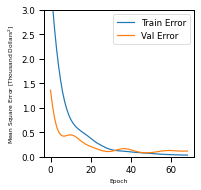

In [ ]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,3])

plot_history()

In [ ]:
test_features_norm = (test_features - train_mean) / train_std
mse, _, _ = model.evaluate(test_features_norm, test_labels)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

1/1 [==============================] - 0s 16ms/step - loss: 0.1029 - mae: 0.2950 - mse: 0.1029
Root Mean Square Error on test set: 0.321


In [ ]:
features_list = ["Carbene HOMO", "Carbene LUMO", "Carbene cation HOMO", "Carbene ox", "HOMO-LUMO", "HOMO+LUMO"]
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

for j in range(1,len(features_list)+1):
    for i in combinations(features_list, j):

        (train_features, train_labels) = (df_dataoverview[list(i)].to_numpy(), df_dataoverview["Enolate ox"].to_numpy())



        reg = linear_model.LinearRegression()
        reg.fit(train_features, train_labels)
        reg.coef_

        print(str(i) + " delivers: " + 
              str(np.round(
                  np.mean(cross_val_score(reg, train_features, train_labels, cv=8, scoring='neg_mean_squared_error')),
              2)))


NameError: ignored

This goes to show that it is not worth it at all to train models with several variables as we can barely beat the accuracy that we can get from the HOMO and LUMO level alone. No matter which combination of how many variables based on the starting carbene we chose, we do not get significant increases in the prediction mean squared errors. It is somewhat surprising that the LUMO is just as good as a predictor as the HOMO level.

#Buried volumes

DBStep was used for conveniently collecting the buried volumes of all enol radicals.

This agrees with SambVca with the following settings:
- central atom not deleted
- bondii radii not scaled

In [63]:
!pip install dbstep

     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 260 kB 8.3 MB/s 
     |████████████████████████████████| 686 kB 10.3 MB/s 
  Created wheel for cclib: filename=cclib-1.7-py3-none-any.whl size=293559 sha256=19d2457ac3d2668a58ec2ef1b15ad8f4ba4a347b28789ff9811138142e60e9f3
  Stored in directory: /root/.cache/pip/wheels/4c/62/5a/952249738ceed50b7d31e883eecb101d404a198842854536fe
  Created wheel for periodictable: filename=periodictable-1.6.0-py3-none-any.whl size=749749 sha256=fb90d78236970da4f0341e85e121cb879aaa939ada772aef2253ae7c9b3c6b1b
  Stored in directory: /root/.cache/pip/wheels/31/d2/e0/764db3104c74c9d991315dc39d1647012d38d9e76851bb16ae
Successfully built cclib periodictable


In [164]:
import dbstep.Dbstep as db

CalcIDs = ["0531", "1231", "1331", "1431", "1731", "1931", "2031", "2331",
           "2431", "2731", "2831", "3031", "3131", "3231", "3431", "3531",
           "3731", "3831", "4031", "4131", "4631", "4731", "4931", "5031",
           "5131", "5231", "5331", "5431", "5531", "5631", "5731", "5831",
           "5931", "6131", "6231", "6331", "6431", "6631", "6831"]
atoms = [12]

for CalcID in CalcIDs:
    for atom in atoms:   
        #Manually upload an xmol format xyz file
        xyzfile = "/content/" + str(CalcID) + ".xyz"
        #Create DBSTEP object
        print("CalcID: " + str(CalcID))
        mol = db.dbstep(xyzfile,atom1=atom,commandline=True,verbose=False,sterimol=False,
                        volume=True,measure='classic', r=3.5)
            


CalcID: 6831
      R/Å     %V_Bur     %S_Bur
     3.50      55.07       0.00


# Figure for redox potential overview

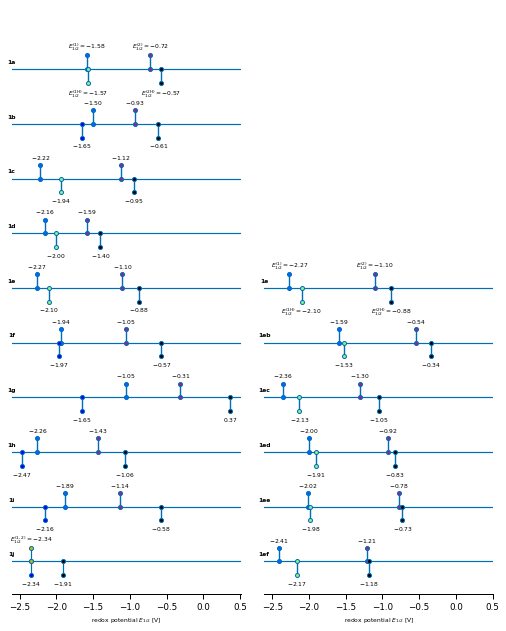

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
def mathtext(number):
    return "$\mathrm{" + str(format(number, '.2f')) + "}$"


full_dataset = False # False for only displaying data in the main manuscript

colors = [cmap4[1], cmap4[0], cmap4[2], cmap4[3]]

ylim = 0

# We pass the dataframes with rows front to back because we will draw the figure
# top to bottom. This makes it easier to make figures of different height but
# with consistent spacing via subplots.
dataframes = [df_dataoverview.loc[reversed(df_dataoverview.index)],
              df_dataoverview_substituents.loc[reversed(df_dataoverview_substituents.index)]]
i = 0

fig, axs = plt.subplots(1,2, figsize=(6.92, 8.66), sharey=True, sharex=True,
                        constrained_layout=True)
lineheight = 1
linemargin = 2 * lineheight
filename_png = "overview.png"

redpot_labels = ['$E_{1/2}^{(1)}=$',
          '$E_{1/2}^{(1\mathrm{H})}=$',
          '$E_{1/2}^{(2)}=$',
          '$E_{1/2}^{(2\mathrm{H})}=$']

for dataframe in dataframes:
    
    

    df_redox = []
    redpot_cols = ["Enolate ox", "Electrolysis", "Enol. ox", "Enol ox"]
    labels = []

    if full_dataset==True:
        df_redox = dataframe[redpot_cols].values.tolist()
        labels = dataframe["Label"].values.tolist()
    else:
        for index in dataframe[redpot_cols].index:
            if index[0]!='S':
                df_redox.append( dataframe[redpot_cols].loc[index].values.tolist())
                labels.append(dataframe["Label"].loc[index])


    # Choose some nice levels
    levels = np.array([lineheight, -lineheight, lineheight, -lineheight])
    baseline = 0
    list_index = 0



    for values in df_redox:

        # Check for 2 electron transfers
        if values[2]<values[0]:

            # Plot average for the 2 e process
            axs[i].vlines((values[2]+values[0])/2, baseline, levels[0], color="#006eb7")
            axs[i].plot((values[2]+values[0])/2, baseline, "o",
                    color="#006eb7", markerfacecolor='y', markersize=4,
                    zorder=2.5)  # Baseline and markers on it.
            axs[i].plot((values[2]+values[0])/2, levels[0], "o",
                    color="#006eb7", markerfacecolor='y', markersize=4)  # Markers at line ends.
            axs[i].annotate("$E_{1/2}^{(1,2)}=$" + mathtext((values[2]+values[0])/2), xy=((values[2]+values[0])/2,levels[0]),
                    xytext=(0, 4), textcoords="offset points",
                    horizontalalignment="center",
                    verticalalignment="bottom")

            # Plot the remaining potentials
            for j in [1,3]:
                axs[i].vlines(values[j], baseline, levels[j], color="#006eb7")
                axs[i].plot(values[j], baseline, "o",
                        color="#006eb7", markerfacecolor=colors[j], markersize=4,
                        zorder=2)  # Baseline and markers on it.
                axs[i].plot(values[j], levels[j], "o",
                        color="#006eb7", markerfacecolor=colors[j], markersize=4)  # Markers at line ends.
                axs[i].annotate(mathtext(values[j]),
                        xy=(values[j], levels[j]),
                        xytext=(0, 4 if levels[j] > baseline else -4), textcoords="offset points",
                        horizontalalignment="center",
                        verticalalignment="bottom" if levels[j] > baseline else "top")
             
        else:
            axs[i].vlines(values, baseline, levels, color="#006eb7")
                    
            for j in range(0,4):
                axs[i].vlines(values[j], baseline, levels[j], color="#006eb7")
                axs[i].plot(values[j], baseline, "o",
                        color="#006eb7",
                        markerfacecolor='lightgreen' if j==1 and values[1]>values[0] else colors[j],
                        markersize=4,
                        zorder=2)  # Baseline and markers on it.
                axs[i].plot(values[j], levels[j], "o",
                        color="#006eb7",
                        markerfacecolor='lightgreen' if j==1 and values[1]>values[0] else colors[j],
                        markersize=4)  # Markers at line ends.
                if values==df_redox[-1]:
                    axs[i].annotate(redpot_labels[j] + mathtext(values[j]),
                            xy=(values[j], levels[j]),
                            xytext=(0, 4 if levels[j] > baseline else -4), textcoords="offset points",
                            horizontalalignment="center",
                            verticalalignment="bottom" if levels[j] > baseline else "top")
                else:
                    axs[i].annotate(mathtext(values[j]), xy=(values[j], levels[j]),
                            xytext=(0, 4 if levels[j] > baseline else -4), textcoords="offset points",
                            horizontalalignment="center",
                            verticalalignment="bottom" if levels[j] > baseline else "top")


        
        # attach the compound label
      
        
        list_index += 1  
        baseline = baseline + (2*lineheight + linemargin)
        levels = levels + (2*lineheight + linemargin)


    # Now attach compound labels. We do this in a second loop so that the overall
    # x limits of our figure are defined.
    baseline = 0
    for label in labels:
        axs[i].axhline(baseline, color="#006eb7", zorder=1)
        axs[i].annotate(label, xy=(axs[i].get_xlim()[0], baseline),
                    xytext=(0, 5), textcoords="offset points",
                    horizontalalignment="center",
                    verticalalignment="bottom",
                    weight='bold')
        baseline = baseline + (2*lineheight + linemargin)


        # add horizontal lines

    # remove y axis and spines
    axs[i].yaxis.set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)

    # Set ylimits with enough margin for adding ChemDraw figures

    if ylim==0:
        ylim = baseline + 0.3 * linemargin
        axs[i].set_ylim(-lineheight - 0.7 * linemargin, ylim)
        
    else:
        axs[i].set_ylim(-lineheight - 0.7 * linemargin, ylim)

    axs[i].set_xlabel("redox potential $E_{1/2}$ [$\mathrm{V}$]")

    i+=1

plt.show()
filename_png = "redpot_overview.png"
fig.savefig(filename_png, dpi=300)

files.download(filename_png)



In [ ]:
df_dataoverview.loc[reversed(df_dataoverview.index)]

,Label,Enolate ox,Enol. ox,S-T,dG addition,dG 1H,dG 1H'',Stable taut,dG addition taut,Electrolysis,Enol ox,pKa,Carbene ox,Carbene HOMO,Carbene LUMO,Carbene cation HOMO,Notes,HOMO-LUMO,HOMO+LUMO,EN Cat,Hardness Cat
Entry,,,,,,,,,,,,,,,,,,,,,
S20,S1t,-2.66,-2.20,-8.22,25.33,-3.77,-10.75,1Has,14.58,-2.69,-2.08,46.3,-0.36,-4.330,0.089,-8.412,acyl shift,-4.419,-4.241,2.0410,6.3710
S19,S1s,-2.38,-2.05,-5.05,20.80,2.54,-4.13,1Has,16.67,-2.15,-1.84,37.1,-0.39,-3.817,-1.142,-7.748,acyl shift,-2.675,-4.959,1.9655,5.7825
S18,S1r,-2.55,-1.91,-6.15,-0.65,14.66,-12.10,1Has,-12.76,-3.26,-1.96,56.0,-0.56,-3.337,-1.002,-9.157,acyl shift,-2.335,-4.339,2.9100,6.2470
10,1j,-2.25,-2.43,-2.86,11.64,2.70,13.57,1H',11.64,-2.34,-1.91,40.3,-0.23,-3.588,-0.874,-8.954,acyl shift,-2.714,-4.462,2.6830,6.2710
S17,S1q,-1.94,-1.06,-0.49,20.99,-10.08,-47.05,1Has,-26.06,-2.70,-1.38,46.4,0.15,-4.312,-2.617,-9.499,acyl shift,-1.695,-6.929,2.5935,6.9055
S16,S1p,-2.04,-1.95,-2.74,15.87,-0.89,-20.71,1Hro,-4.84,-1.79,-1.63,31.0,0.29,-4.334,-1.641,-8.971,ring-opening,-2.693,-5.975,2.3185,6.6525
S15,S1o,-1.99,-1.51,-5.05,4.76,11.36,-20.58,1H'',-15.82,-2.83,-1.59,48.7,0.28,-4.191,-1.977,-11.243,NaN,-2.214,-6.168,3.5260,7.7170
S14,S1n,-2.11,-2.21,-0.81,12.12,11.63,-36.76,1Hro,-24.64,-3.91,-1.90,66.9,0.37,-4.083,-1.028,-10.012,ring-opening,-3.055,-5.111,2.9645,7.0475
9,1i,-2.22,-1.12,3.54,12.89,-5.45,-0.07,1H,7.44,-1.94,-0.95,33.6,0.91,-4.651,-2.137,-8.879,NaN,-2.514,-6.788,2.1140,6.7650


In [ ]:
df_logreg = pd.read_csv('Book1.csv',
                        index_col=0)
percent_cols = ['Vbur CO\n[%]', 'Vbur C:\n[%]', 'Vbur C:\n[%].1']

for col in percent_cols:
    df_logreg[col] = df_logreg[col].str.rstrip('%').astype('float') / 100.0
    #                     ^ use str funcs to elim '%'     ^ divide by 100
    # could also be:     .str[:-1].astype(...
df_logreg

,Enol. ox\n[eV],S-T\n[kcal mol?1],dG addition\n[kcal mol?1],dG 1H\n[kcal mol?1],dG 1H''\n[kcal mol?1],dG addition taut\n[kcal mol?1],Electrolysis\n[eV],Enol ox\n[eV],pKa,Carbene ox\n[eV],Carbene HOMO\n[eV],Carbene LUMO\n[eV],Carbene cation HOMO\n[eV],Vbur CO\n[%],fract. spin d. CO,RadStabScore CO,Vbur C:\n[%],fract. spin d. C:,RadStabScore C:,Vbur C:\n[%].1,fract. spin d. C:.1,RadStabScore tot,BDE Enol CH\n[kcal/mol],BDE ketone CH\n[kcal/mol],BDE Zwitter CH\n[kcal/mol],Catalyst
Enolate ox [eV],,,,,,,,,,,,,,,,,,,,,,,,,,
-1.58,-0.72,26.60,10.97,-10.73,-13.20,-2.23,-1.57,-0.57,127676.8,1.10,-5.052,-1.506,-9.972,0.5583,0.110,100.33,0.6317,0.242,101.070,0.6317,0.242,101.070,43.59,46.07,32.86,True
-1.50,-0.93,18.44,15.98,-5.14,-10.51,5.47,-1.65,-0.61,127678.1,1.19,-5.223,-2.123,-9.256,0.5926,0.104,104.06,0.6628,0.279,69.190,0.6628,0.279,69.190,44.19,49.55,39.04,True
-2.27,-1.10,17.20,14.28,-4.10,1.98,10.18,-2.10,-0.88,127685.7,1.05,-4.938,-1.228,-9.116,0.7082,0.173,112.17,0.7952,0.187,80.410,0.5828,0.267,65.790,42.19,36.11,38.09,False
-1.94,-1.05,23.30,13.39,-8.93,-3.15,4.45,-1.97,-0.57,127683.5,0.84,-4.784,-1.122,-8.966,0.7263,0.127,116.28,0.8176,0.310,75.380,0.8176,0.310,75.380,46.89,41.10,37.95,False
-1.05,-0.31,21.02,3.69,-9.56,-17.67,-13.98,-1.65,0.37,127678.1,0.93,-4.986,-2.808,-9.089,0.7125,0.046,118.95,0.8428,0.456,69.340,0.8428,0.456,69.340,51.91,60.02,42.35,NaN
-2.26,-1.43,21.05,9.17,-2.84,-10.80,-1.63,-2.47,-1.06,127692.0,0.38,-4.197,-0.149,-9.336,0.5703,0.164,98.83,0.6461,0.159,74.355,0.6461,0.159,74.355,42.95,50.90,40.10,NaN
-1.89,-1.14,20.74,18.23,-18.44,-22.66,-4.43,-2.16,-0.58,127686.8,-0.65,-3.634,0.146,-8.684,0.7164,0.091,117.09,0.8392,0.397,72.110,0.8392,0.397,72.110,48.21,52.43,29.77,NaN
-2.16,-1.59,2.60,6.37,4.38,5.21,6.37,-2.00,-1.40,127684.1,0.43,-4.287,-2.180,-8.432,0.6720,0.146,109.90,0.7721,0.144,81.405,0.7721,0.144,81.405,38.07,37.24,42.45,NaN
-2.22,-1.12,3.54,12.89,-5.45,-0.07,7.44,-1.94,-0.95,127683.0,0.91,-4.651,-2.137,-8.879,0.6630,0.153,108.65,0.7590,0.128,81.550,0.6741,0.222,72.605,39.80,34.42,34.35,True


In [ ]:
df_logreg = df_logreg.reset_index()
df_train = df_logreg.dropna()
X_train = df_train.drop(columns='Catalyst')
y_train = df_train['Catalyst'].astype('bool')

In [ ]:
df_test = df_logreg[df_logreg.Catalyst != True]
df_test = df_logreg[df_logreg.Catalyst != False]
X_test = df_test.drop(columns='Catalyst')
y_test = df_test['Catalyst']

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

coef = logreg.coef_[0]
print (coef)

[ 1.34111480e-02  6.01167693e-03 -1.60807202e-01 -2.19823881e-02
 -2.34700296e-02 -2.91091172e-01 -1.48870303e-01  1.24860886e-02
  5.93579092e-04 -1.78244675e-05  4.82552034e-03 -4.54122848e-03
 -2.96196295e-02 -1.30197863e-02 -4.46395473e-03 -1.09671116e-03
 -3.91477634e-01 -4.83188402e-03 -1.27495023e-03  2.39674141e-01
 -1.74339703e-03 -1.61851821e-03  4.11276890e-01 -7.97527104e-02
  1.88066668e-01 -1.03156667e-01]


In [ ]:
logreg.predict(X_test)

array([ True,  True,  True,  True,  True,  True,  True, False])

In [ ]:
pd.DataFrame([coef, df_logreg.columns])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0.0134111,0.00601168,-0.160807,-0.0219824,-0.02347,-0.291091,-0.14887,0.0124861,0.000593579,-1.78245e-05,0.00482552,-0.00454123,-0.0296196,-0.0130198,-0.00446395,-0.00109671,-0.391478,-0.00483188,-0.00127495,0.239674,-0.0017434,-0.00161852,0.411277,-0.0797527,0.188067,-0.103157,None
1,Enolate ox\n[eV],Enol. ox\n[eV],S-T\n[kcal mol?1],dG addition\n[kcal mol?1],dG 1H\n[kcal mol?1],dG 1H''\n[kcal mol?1],dG addition taut\n[kcal mol?1],Electrolysis\n[eV],Enol ox\n[eV],pKa,Carbene ox\n[eV],Carbene HOMO\n[eV],Carbene LUMO\n[eV],Carbene cation HOMO\n[eV],Vbur CO\n[%],fract. spin d. CO,RadStabScore CO,Vbur C:\n[%],fract. spin d. C:,RadStabScore C:,Vbur C:\n[%].1,fract. spin d. C:.1,RadStabScore tot,BDE Enol CH\n[kcal/mol],BDE ketone CH\n[kcal/mol],BDE Zwitter CH\n[kcal/mol],Catalyst


In [ ]:
df_logreg2  = df_logreg

df_predictcoefs = pd.DataFrame([coef, df_logreg.columns]).transpose()
df_predictcoefs[0] = df_predictcoefs[0].astype('float')

for i in df_predictcoefs.index:
    if -0.1 < df_predictcoefs[0][i] < 0.1:
        df_logreg2 = df_logreg2.drop(columns=df_predictcoefs[1][i])
df_logreg2

,S-T\n[kcal mol?1],dG 1H''\n[kcal mol?1],dG addition taut\n[kcal mol?1],RadStabScore CO,RadStabScore C:,RadStabScore tot,BDE ketone CH\n[kcal/mol],BDE Zwitter CH\n[kcal/mol],Catalyst
0,26.60,-13.20,-2.23,100.33,101.070,101.070,46.07,32.86,True
1,18.44,-10.51,5.47,104.06,69.190,69.190,49.55,39.04,True
2,17.20,1.98,10.18,112.17,80.410,65.790,36.11,38.09,False
3,23.30,-3.15,4.45,116.28,75.380,75.380,41.10,37.95,False
4,21.02,-17.67,-13.98,118.95,69.340,69.340,60.02,42.35,NaN
5,21.05,-10.80,-1.63,98.83,74.355,74.355,50.90,40.10,NaN
6,20.74,-22.66,-4.43,117.09,72.110,72.110,52.43,29.77,NaN
7,2.60,5.21,6.37,109.90,81.405,81.405,37.24,42.45,NaN
8,3.54,-0.07,7.44,108.65,81.550,72.605,34.42,34.35,True
9,-2.86,13.57,11.64,106.43,80.230,53.555,31.66,45.30,NaN


In [ ]:
df_train = df_logreg2.dropna()
X_train = df_train.drop(columns='Catalyst')
y_train = df_train['Catalyst'].astype('bool')

In [ ]:
df_test = df_logreg2[df_logreg2.Catalyst != True]
df_test = df_logreg2[df_logreg2.Catalyst != False]
X_test = df_test.drop(columns='Catalyst')
y_test = df_test['Catalyst']

# Buried volumes

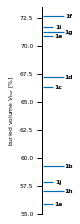

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [115]:
full_dataset = False # False for only displaying data in the main manuscript

colors = [cmap4[1], cmap4[0], cmap4[2], cmap4[3]]

# We pass the dataframes with rows front to back because we will draw the figure
# top to bottom. This makes it easier to make figures of different height but
# with consistent spacing via subplots.
dataframes = [df_dataoverview]#,
              #df_dataoverview_substituents]
i = 0

fig, ax = plt.subplots(1,1, figsize=(1, 3),
                        constrained_layout=True)
lineheight = 1
linemargin = 2 * lineheight
filename_png = "overview.png"

cols = ['$V_{\mathrm{bur}}$']

for dataframe in dataframes:

    df_redox = []
    redpot_cols = ["Vbur CO"]
    labels = []
    dataframe = dataframe.sort_values(redpot_cols)
    if full_dataset==True:
        df_redox = dataframe[redpot_cols].values.tolist()
        labels = dataframe["Label"].values.tolist()
    else:
        for index in dataframe[redpot_cols].index:
            if index[0]!='S':
                df_redox.append( dataframe[redpot_cols].loc[index].values.tolist())
                
                labels.append(dataframe["Label"].loc[index])
    
    df_redox = np.multiply(df_redox,100)


    # Choose some nice levels
    levels = np.array([lineheight, -lineheight, lineheight, -lineheight])
    baseline = 0
    list_index = 0



    for idx,label_value in enumerate(zip(labels, df_redox)):
        if idx % 2 == 0:
            x=0.5
        else:
            x=1
        # Plot the remaining potentials
        ax.hlines(label_value[1], 0, x, color="#006eb7")
        #ax.plot([0,5], [values, values], "-",
        #        color="#006eb7", markerfacecolor=colors[0], markersize=4,
        #        zorder=2)  # Baseline and markers on it.
        #ax.plot(0, values, "o",
        #        color="#006eb7", markerfacecolor=colors[0], markersize=4)  # Markers at line ends.
        #ax.annotate(mathtext(values),
        #        xy=(0, values),
        #        xytext=(0, 4 if levels[0] > baseline else -4), textcoords="offset points",
        #        horizontalalignment="center",
        #        verticalalignment="bottom" if levels[0] > baseline else "top")


        
        # attach the compound label
      
        
        list_index += 1  

        levels = levels + (2*lineheight + linemargin)


    # Now attach compound labels. We do this in a second loop so that the overall
    # x limits of our figure are defined.
        ax.annotate(label_value[0], xy=(x, label_value[1]),
                    xytext=(5, 0), textcoords="offset points",
                    horizontalalignment="center",
                    verticalalignment="center",
                    weight='bold')



        # add horizontal lines

    # remove y axis and spines
    ax.xaxis.set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set ylimits with enough margin for adding ChemDraw figures

    #ax.set_ylim(0.5, 1)
    ax.set_ylabel(r"buried volume $V_{bur}$ [$\mathrm{\%}$]")

    i+=1

plt.show()
filename_png = "redpot_overview.png"
fig.savefig(filename_png, dpi=300)

files.download(filename_png)

